# RDkitでフィンガープリントを算出する

フィンガープリントとは、何かしらの演算によって分子中の部分構造の有無をバイナリ[ 0 or 1 ]に変換したものです.  
ある分子$M$が$n$個の部分構造$m_n$から成るとき, 以下のようにそれらの部分構造の集合を１つの分子に対応づけることができます.  

$$ M = \{ m_1, m_2, m_3, ..., m_n \} $$

ここで, 事前定義しておいた$i$個の部分構造$S=\{ s_1, s_2, s_3, ..., s_i\}$について, $M$が$s_i$を含むかどうかを$0, 1$で表すことで, 以下のような, $|S|$の配列長ベクトルを得ることができます.
$$vector  = ( x_1, x_2, x_3, ..., x_i) $$

$$
\begin{cases}
    x_i=1 & \text{if $s_i \in M$} \\
    x_i=0                 & \text{else} \\
  \end{cases}
$$  

このように何かしらの演算によって化学構造を数値に変換していくメリットは, その後のコンピュータによる演算が容易になることです. ケモインフォマティクスでは分子をベクトルや行列に変換した上で, そこに数学的な演算を施してくの一般的です. 化学をコンピュータで扱うために, 数学で扱える問題設定にすり替えていくわけです.

# Extended Connectivite Fingerprints (ECFP)
ECFPとは, 現在一般的に用いられているフィンガープリントの１つです. 原子からある半径の距離にある部分構造を数え上げていく,**circular substructures**と呼ばれるアルゴリズムに基づいております. これは, データセット中の分子の特徴に基づき, フィンガープリントとして用いるための部分構造を定義していくアルゴリズムです. ECFPと同じようなフィンガープリントに**Morganフィンガープリント**と呼ばれるものもあり, こちらもよく用いられます. アルゴリズムはECFPとほとんど同じですが, 用いている$hash$関数 (後述) が異なるなどの影響で結果はECFPと完全には一致しません. 一方で, ECFPとは対象的に, データセット非依存的に部分構造が事前定義されたフィンガープリントにはRDkitフィンガープリントなどがあります.  
以下に, ECFPのザックリとしたアルゴリズムの説明を載せます ([Rogers, D. and Hahn, M. **2010** *J. Chem. Inf. Model.*](https://pubs.acs.org/doi/10.1021/ci100050t)). 

1. 分子中の各原子に原子に特有の番号を振る (論文では番号でなくベクトルとなってますが, 説明の簡易化のため番号で進めます)  
2. 自身の原子の番号と, 隣接する原子の番号を並べて結合した配列を作る  
3. 2の操作を分子中の全ての原子に付いて行う  
4. $hash$関数と呼ばれる特別な関数で, 2~3で得られた配列に新たに番号をふる  
5. 新たに生成された番号をそれぞれビット値(FPの次元数と同じ)と呼ばれる事前に定義しておいた数で割った余りを求める (mod計算)
6. 5で求めた余りをindexとして, その番号の場所に１を代入する. (1が入らないところは0)  

以上のアルゴリズムで, 半径$r$の近傍のフィンガープリントを得るためには, 2~6を$r$回繰り返せば可能です.
<br>

![ECFP](../imgs/ECFP.png) 

# Morgan フィンガープリントの算出

必要なライブラリをインポートする

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

関数を定義

In [11]:
def mol2morganfp(mol, radius, nBits):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(
        mol,
        radius=radius,
        nBits=nBits,
        bitInfo=bitInfo
        )
    return fp, bitInfo


def fp2img(mol, radius, nBits):
    fp, bitInfo = mol2morganfp(mol, radius, nBits)
    bitIds = list(fp.GetOnBits())
    results = [Draw.MolToImage(mol)]
    for bitId in bitIds:
        results.append(Draw.DrawMorganBit(mol, bitInfo=bitInfo, bitId=bitId))
    return results

サンプルデータの読み込み

In [12]:
# サンプルSMILESを取得
smiles = pd.read_csv("water_solubility.csv").SMILES.tolist()
# molを生成する
mols = [Chem.MolFromSmiles(smi) for smi in smiles if Chem.MolFromSmiles(smi) is not None]

RDKit WARNING: [14:56:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:56:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:56:17] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [14:56:17] Explicit valence for atom # 6 O, 3, is greater than permitted


In [13]:
morgan_vec = [np.array(mol2morganfp(mol, 2, 1024)[0]) for mol in mols]
df_morgan = pd.DataFrame(morgan_vec)
df_morgan.insert(0, "SMILES", [Chem.MolToSmiles(mol) for mol in mols])

In [14]:
df_morgan

,SMILES,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CC(N)=O,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CNN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CC(=O)O,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,C1CCNC1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NC(=O)NO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,Clc1ccc(Cl)c(-c2c(Cl)ccc(Cl)c2Cl)c1Cl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1285,c1ccc2c(c1)ccc1cc3c(ccc4ccccc43)cc12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1286,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1287,Clc1cc(-c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl)c(Cl)c(Cl)c1Cl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ここで, 0番目の化合物のフィンガープリントは1024次元のベクトルで表記されていることとなります

In [15]:
vector = np.array(df_morgan.iloc[0,1:])
print(vector.shape)
print(vector)

(1024,)
[0 0 0 ... 0 0 0]


# それぞれのbitに対応する部分構造を可視化する

In [ ]:
morgan_imgs = fp2img(mols[3], 2, 1024)

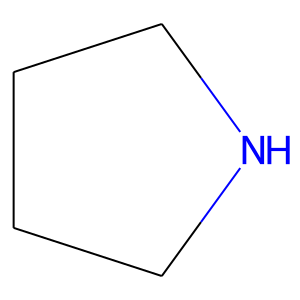

In [17]:
# 0番目は元の分子になります
morgan_imgs[0]

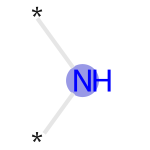

In [18]:
morgan_imgs[3]